# New York City Taxi Fare Prediction
Can you predict a rider's taxi fare?

## Objective
Predict the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations

## Description
In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

# Data Source
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

# File descriptions
- **train.csv** - Input features and target fare_amount values for the training set (about 55M rows).
- **test.csv** - Input features for the test set (about 10K rows). Your goal is to predict fare_amount for each row.
- **sample_submission.csv** - a sample submission file in the correct format (columns key and fare_amount). This file 'predicts' fare_amount to be $11.35 for all rows, which is the mean fare_amount from the training set.

# Data fields

## ID
- **key** - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.

## Features
- **pickup_datetime** - timestamp value indicating when the taxi ride started.
- **pickup_longitude** - float for longitude coordinate of where the taxi - ride started.
- **pickup_latitude** - float for latitude coordinate of where the taxi ride started.
- **dropoff_longitude** - float for longitude coordinate of where the taxi ride ended.
- **dropoff_latitude** - float for latitude coordinate of where the taxi ride ended.
- **passenger_count** - integer indicating the number of passengers in the taxi ride.

## Target
- **fare_amount** - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.

In [2]:
# import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# jupyter notebook configurations
%matplotlib inline
sns.set_style('whitegrid')
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columns
# pd.set_option("display.max_rows", 1000)
# pd.set_option("display.max_columns", 1000)

# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [38]:
# load dataset
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Krish/New York Taxi/taxifare.csv")  # this is a sampled dataset

# Explore Dataset

In [39]:
# preview dataset
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [40]:
df.tail()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
119995,2010-04-18 14:33:03 UTC,15.3,1,-73.955857,40.784590,-73.981941,40.736789,1
119996,2010-04-23 10:27:48 UTC,15.3,1,-73.996329,40.772727,-74.049890,40.740413,1
119997,2010-04-18 18:50:40 UTC,12.5,1,-73.988574,40.749772,-74.011541,40.707799,3
119998,2010-04-13 08:14:44 UTC,4.9,0,-74.004449,40.724529,-73.992697,40.730765,1
119999,2010-04-17 16:00:14 UTC,5.3,0,-73.955415,40.771920,-73.967623,40.763015,3


- `pickup_datetime` is in UTC time
- UTC is 4 hours ahead of New York Time

In [41]:
# size of dataset
print("# Rows:", df.shape[0])
print("# Cols:", df.shape[1])

# Rows: 120000
# Cols: 8


In [42]:
# features of dataset
for i in df.columns: print(i)

pickup_datetime
fare_amount
fare_class
pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude
passenger_count


In [43]:
# metadata - data makeup and structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


- no missing values
- `pickup_datetime` is object data type, i.e., it is a string. We will have to convert it into datetime

In [44]:
# check for missing values
df.isnull().sum()

pickup_datetime      0
fare_amount          0
fare_class           0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [45]:
# metadata - stats on numerical features
df.describe()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,10.040326,0.333333,-73.976626,40.751443,-73.974501,40.751695,1.347167
std,7.500134,0.471406,0.031497,0.025821,0.032419,0.030279,0.759263
min,2.500000,0.000000,-74.465447,40.121653,-74.443323,40.164927,1.000000
25%,5.700000,0.000000,-73.992386,40.736594,-73.991478,40.735914,1.000000
50%,7.700000,0.000000,-73.982084,40.753661,-73.980411,40.754441,1.000000
75%,11.300000,1.000000,-73.968710,40.768020,-73.965500,40.768880,1.000000
max,49.900000,1.000000,-73.311845,40.981292,-73.496140,40.993498,5.000000


# Feature Engineering

In [46]:
# convert 'pickup_datetime' into datetime data type
import datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']) - datetime.timedelta(hours=4)  # convert into datetime and subtract 4 hours to bring to NYC time

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(2)
memory usage: 7.3 MB


In [48]:
# preview dataset
df.head(3)  # 'pickup_datetime' feature has been transformed

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 04:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 11:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 07:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2


In [49]:
# create new features for timestamps
df['year'] = df['pickup_datetime'].dt.year  # year
df['month'] = df['pickup_datetime'].dt.month  # month in year
df['day'] = df['pickup_datetime'].dt.day  # day of the month
df['hour'] = df['pickup_datetime'].dt.hour  # hour of the day
df['minute'] = df['pickup_datetime'].dt.minute  # minute
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek # gives only the index(0-monday,6-sunday)
df['weekend'] = np.where(df['day_of_week']==5,1,0)  # weekend or not < saturday
df['weekend'] = np.where(df['day_of_week']==6,1,0)  # weekend or not < sunday

In [50]:
# preview dataset
df.head(10)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute,day_of_week,weekend
0,2010-04-19 04:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2010,4,19,4,17,0,0
1,2010-04-17 11:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,2010,4,17,11,43,5,0
2,2010-04-17 07:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2010,4,17,7,23,5,0
3,2010-04-11 17:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2010,4,11,17,25,6,1
4,2010-04-16 22:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2010,4,16,22,19,4,0
5,2010-04-22 04:39:47+00:00,8.1,0,-73.980481,40.748995,-73.983508,40.766459,1,2010,4,22,4,39,3,0
6,2010-04-23 15:27:00+00:00,4.9,0,-73.959535,40.779582,-73.947185,40.780223,1,2010,4,23,15,27,4,0
7,2010-04-15 05:03:37+00:00,4.9,0,-74.002601,40.739419,-73.997912,40.730292,1,2010,4,15,5,3,3,0
8,2010-04-20 04:58:00+00:00,2.9,0,-74.014005,40.704058,-74.013202,40.702877,1,2010,4,20,4,58,1,0
9,2010-04-16 14:50:16+00:00,6.1,0,-73.977689,40.784175,-73.988639,40.778669,1,2010,4,16,14,50,4,0


In [51]:
# create feature of AM & PM
df['time_AM'] = np.where(df['hour']<12,0,1)

In [52]:
# drop 'pickup_datetime'
df.drop(['pickup_datetime'], axis=1, inplace=True)

In [53]:
# preview dataset
df.head(3)

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute,day_of_week,weekend,time_AM
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2010,4,19,4,17,0,0,0
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,2010,4,17,11,43,5,0,0
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2010,4,17,7,23,5,0,0


In [54]:
!pip install haversine

In [55]:
from haversine import haversine, Unit

total_distance = []
for i in range(df.shape[0]):
  loc1 = (df['pickup_longitude'][i], df['pickup_latitude'][i]) # (lat, lon)
  loc2 = (df['dropoff_longitude'][i], df['dropoff_latitude'][i])
  total_distance.append(haversine(loc1, loc2))

In [56]:
df['total_distance'] = total_distance

In [57]:
df.head(10)

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute,day_of_week,weekend,time_AM,total_distance
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2010,4,19,4,17,0,0,0,1.925525
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,2010,4,17,11,43,5,0,0,1.765372
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2010,4,17,7,23,5,0,0,3.818378
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2010,4,11,17,25,6,1,1,2.158664
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2010,4,16,22,19,4,0,1,9.457777
5,8.1,0,-73.980481,40.748995,-73.983508,40.766459,1,2010,4,22,4,39,3,0,0,0.632792
6,4.9,0,-73.959535,40.779582,-73.947185,40.780223,1,2010,4,23,15,27,4,0,1,1.373401
7,4.9,0,-74.002601,40.739419,-73.997912,40.730292,1,2010,4,15,5,3,3,0,0,0.591695
8,2.9,0,-74.014005,40.704058,-74.013202,40.702877,1,2010,4,20,4,58,1,0,0,0.096336
9,6.1,0,-73.977689,40.784175,-73.988639,40.778669,1,2010,4,16,14,50,4,0,1,1.229249


In [58]:
df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1, inplace=True)

In [59]:
df.head()

,fare_amount,fare_class,passenger_count,year,month,day,hour,minute,day_of_week,weekend,time_AM,total_distance
0,6.5,0,1,2010,4,19,4,17,0,0,0,1.925525
1,6.9,0,1,2010,4,17,11,43,5,0,0,1.765372
2,10.1,1,2,2010,4,17,7,23,5,0,0,3.818378
3,8.9,0,1,2010,4,11,17,25,6,1,1,2.158664
4,19.7,1,1,2010,4,16,22,19,4,0,1,9.457777


In [66]:
# size of dataset
print("# Rows:", df.shape[0])
print("# Cols:", df.shape[1])

# Rows: 120000
# Cols: 12


# Train Test Split

In [61]:
# split dependent and independent features
X = df.drop(['fare_amount'], axis=1)  # dependent features
y = df['fare_amount']  # independent features

In [62]:
# train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 0)

## Important Features
Retrieve the most important features for modelling with Extra Trees Regressor

In [63]:
# feature selection
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

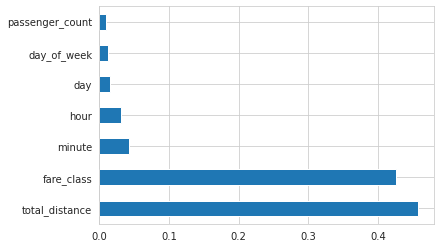

In [73]:
# plot features based on their importance
important_features = pd.Series(model.feature_importances_, index=X.columns)
important_features.nlargest(7).plot(kind='barh')  # 7 most important features
plt.show()

# Modelling

In [78]:
# XGBoost Regressor
import xgboost
reg = xgboost.XGBRegressor()  # initialize model
reg.fit(X_train,y_train)  # model training

[15:49:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

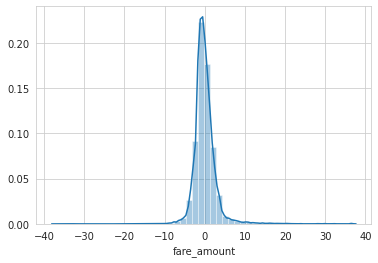

In [80]:
# predictions
preds = reg.predict(X_test) # make predictions
sns.distplot(y_test - preds)  # error distribution plot

In [ ]:
plt.scatter(y_test, preds)

In [82]:
# model evauluation
from sklearn import metrics
print("R-square:", np.sqrt(metrics.r2_score(y_test, preds)))
print("MAE:", metrics.mean_absolute_error(y_test, preds))
print("MSE:", metrics.mean_squared_error(y_test,preds))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, preds)))

R-square: 0.9145916756794913
MAE: 1.8078180181834433
MSE: 9.156011874361917
RMSE: 3.0258902614539607


In [83]:
# hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV

In [84]:

print(n_estimators)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


In [86]:
# randomized search cv

# number of trees
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]
# learning rate parameters
learning_rate = ['0.05','0.1','0.2','0.3','0.5','0.6']
# max number of levels in tree
max_depth = [int(x) for x in np.linspace(5,30,num=6)]
# subsample parameter values
subsample=[0.7, 0.6, 0.8]
# minimum child weight parameters
min_child_weight = [3,4,5,6,7]
# create random grid
param_distributions = {
    'n_estimators':n_estimators,
    'learning_rate':learning_rate,
    'max_depth':max_depth,
    'subsample':subsample,
    'min_child_weight':min_child_weight
}
# preview random grid
print(param_distributions)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'learning_rate': ['0.05', '0.1', '0.2', '0.3', '0.5', '0.6'], 'max_depth': [5, 10, 15, 20, 25, 30], 'subsample': [0.7, 0.6, 0.8], 'min_child_weight': [3, 4, 5, 6, 7]}


In [87]:
# run randomized search cv to find best parameters for modelling

# create base model
reg = xgboost.XGBRegressor()
# search across all combinations with 5 fold cross validations
xgb_random = RandomizedSearchCV(
    estimator=reg, 
    param_distributions=param_distributions, 
    scoring='neg_mean_squared_error', 
    n_iter=5, 
    cv=5, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1)

In [88]:
# training with tuned model
xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 66.0min finished


[17:25:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                   param_distributions={'learning_rate': ['0.05', '0.1', '0.2',
                                                          '0.3', '0.5', '0.6'],
                            

In [89]:
# find best parameters
xgb_random.best_params_

{'learning_rate': '0.05',
 'max_depth': 25,
 'min_child_weight': 6,
 'n_estimators': 1100,
 'subsample': 0.8}

In [ ]:
# predictions
preds = xgb_random.predict(X_test)
# error distribution plot
sns.distplot(y_test-preds)

In [ ]:
# scatter plot
plt.scatter(y_test, preds)

In [ ]:
# model evauluation
from sklearn import metrics
print("R-square:", np.sqrt(metrics.r2_score(y_test, preds)))
print("MAE:", metrics.mean_absolute_error(y_test, preds))
print("MSE:", metrics.mean_squared_error(y_test,preds))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, preds)))